In [ ]:
!nvcc --version 

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Wed_Apr_11_23:16:29_CDT_2018
Cuda compilation tools, release 9.2, V9.2.88


In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Wed_Apr_11_23:16:29_CDT_2018
Cuda compilation tools, release 9.2, V9.2.88


In [ ]:
!nvidia-smi

Fri Mar 12 12:59:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

''

In [ ]:
import tensorflow as tf

In [ ]:
%tensorflow_version 2.x

In [ ]:
#!unzip -qq /content/drive/MyDrive/ECG5000.zip

In [ ]:
ls

cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb  ECG5000_TRAIN.arff
drive/                                             ECG5000_TRAIN.ts
ECG5000_TEST.arff                                  ECG5000_TRAIN.txt
ECG5000_TEST.ts                                    ECG5000.txt
ECG5000_TEST.txt                                   sample_data/


In [ ]:
!pip install -qq arff2pandas

In [ ]:
!pip install -q -U watermark

In [ ]:
import pandas as pd

In [ ]:
pd.__version__

'1.1.5'

In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,arff2pandas

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 5.5.0

numpy      : 1.19.5
pandas     : 1.1.5
torch      : 1.8.0+cu101
arff2pandas: 1.0.1



In [ ]:
import torch

In [ ]:
import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split

from torch import nn, optim

import torch.nn.functional as F
from arff2pandas import a2p


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
print(device)

cuda


In [ ]:
with open('ECG5000_TRAIN.arff') as f:
  train = a2p.load(f)

with open('ECG5000_TEST.arff') as f:
  test = a2p.load(f)

In [ ]:
type(train)

pandas.core.frame.DataFrame

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Columns: 141 entries, att1@NUMERIC to target@{1,2,3,4,5}
dtypes: float64(140), object(1)
memory usage: 550.9+ KB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Columns: 141 entries, att1@NUMERIC to target@{1,2,3,4,5}
dtypes: float64(140), object(1)
memory usage: 4.8+ MB


In [ ]:
train.columns

Index(['att1@NUMERIC', 'att2@NUMERIC', 'att3@NUMERIC', 'att4@NUMERIC',
       'att5@NUMERIC', 'att6@NUMERIC', 'att7@NUMERIC', 'att8@NUMERIC',
       'att9@NUMERIC', 'att10@NUMERIC',
       ...
       'att132@NUMERIC', 'att133@NUMERIC', 'att134@NUMERIC', 'att135@NUMERIC',
       'att136@NUMERIC', 'att137@NUMERIC', 'att138@NUMERIC', 'att139@NUMERIC',
       'att140@NUMERIC', 'target@{1,2,3,4,5}'],
      dtype='object', length=141)

In [ ]:
print(train.describe())

       att1@NUMERIC  att2@NUMERIC  ...  att139@NUMERIC  att140@NUMERIC
count    500.000000    500.000000  ...      500.000000      500.000000
mean      -0.159100     -1.551951  ...       -0.602488       -0.805451
std        1.140292      1.416321  ...        1.946638        1.438395
min       -3.694197     -5.117621  ...       -5.639460       -5.797645
25%       -0.928707     -2.644930  ...       -1.970478       -1.663648
50%       -0.216883     -1.539340  ...       -0.233793       -0.663025
75%        0.582008     -0.595632  ...        1.002865        0.222464
max        4.058127      2.087844  ...        2.589474        2.854707

[8 rows x 140 columns]


**In the training set there are 500 entries and in test there are 4500 entries. Lets combine and shuffle them**

In [ ]:
df=train.append(test)

df = df.sample(frac=1.0)

df.shape

(5000, 141)

In [ ]:
print(df.head())

      att1@NUMERIC  att2@NUMERIC  ...  att140@NUMERIC  target@{1,2,3,4,5}
1001      1.469756     -1.048520  ...       -1.039932                   1
2086     -1.998602     -3.770552  ...        0.799517                   1
2153     -1.187772     -3.365038  ...       -0.824489                   1
555       0.604969     -1.671363  ...        0.023843                   1
205      -1.197203     -3.270123  ...        1.734676                   1

[5 rows x 141 columns]


**We are having 140 attributes for every record and a target field that gives whether the record belongs to the anamoly or normal heart beat**

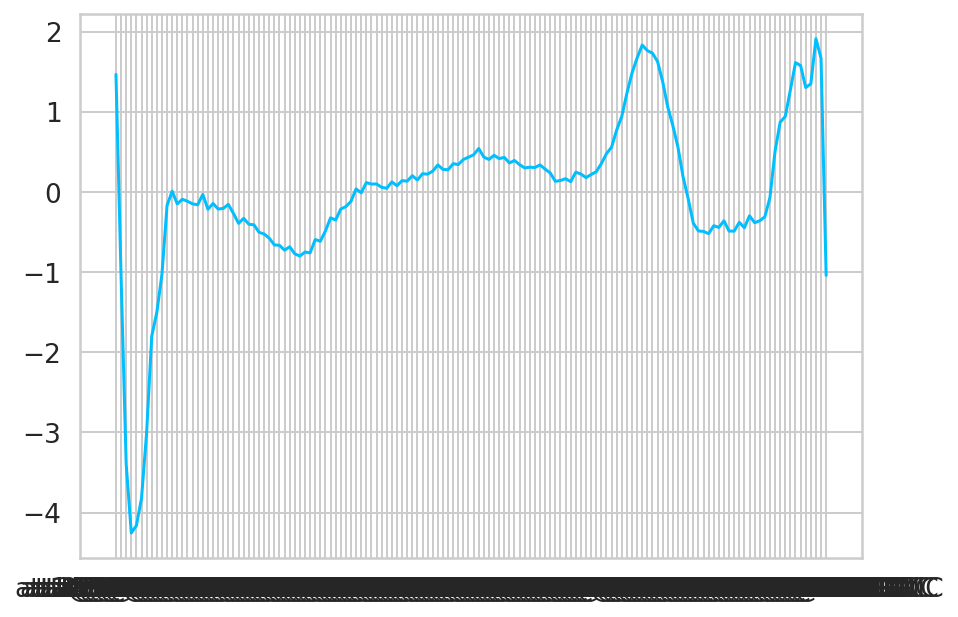

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(df.iloc[0,0:-1])

**This image shows the ecg signal of a normal heart beat as the target value is 1**

In [ ]:
print(df.tail())

      att1@NUMERIC  att2@NUMERIC  ...  att140@NUMERIC  target@{1,2,3,4,5}
3926     -0.248881     -1.346474  ...       -0.378163                   2
466      -0.287286     -1.199089  ...        0.075742                   2
2592     -1.032096     -2.811901  ...        0.750669                   1
3272     -1.592541     -2.461370  ...        0.354016                   2
360      -1.945586     -3.840519  ...       -1.366044                   1

[5 rows x 141 columns]


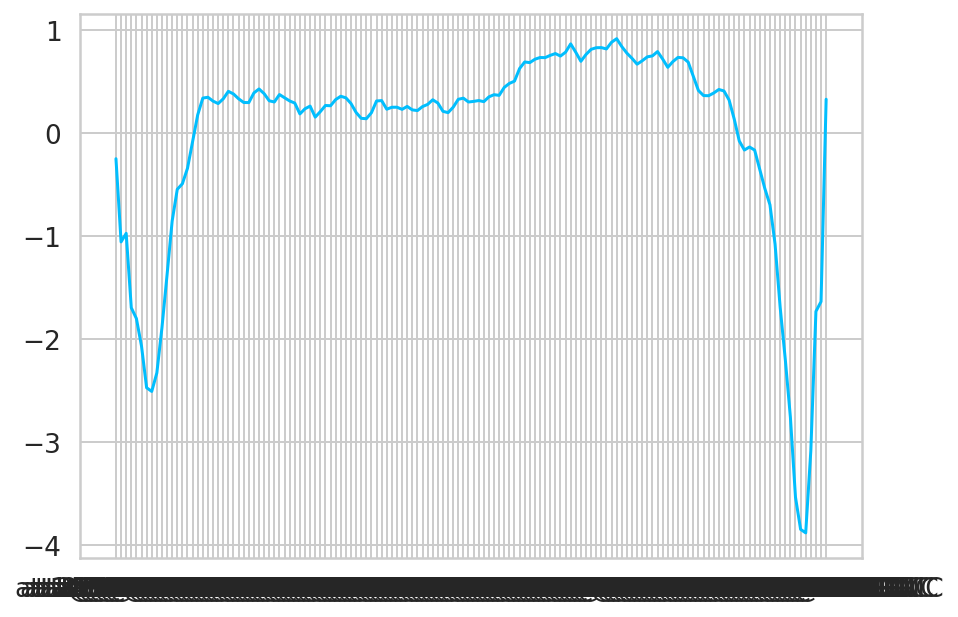

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(df.iloc[3926,0:-1])

**This plot shows how the anamoly ecg signal looks like**

**Data**


The dataset contains 5,000 Time Series examples (obtained with ECG) with 140 timesteps. Each sequence corresponds to a single heartbeat from a single patient with congestive heart failure.

An electrocardiogram (ECG or EKG) is a test that checks how your heart is functioning by measuring the electrical activity of the heart. With each heart beat, an electrical impulse (or wave) travels through your heart. This wave causes the muscle to squeeze and pump blood from the heart. Source

We have 5 types of hearbeats (classes):

-   Normal (N)
-   R-on-T Premature Ventricular Contraction (R-on-T PVC)
-   Premature Ventricular Contraction (PVC)
-   Supra-ventricular Premature or Ectopic Beat (SP or EB)
-   Unclassified Beat (UB)


Assuming a healthy heart and a typical rate of 70 to 75 beats per minute, each cardiac cycle, or heartbeat, takes about 0.8 seconds to complete the cycle. Frequency: 60–100 per minute (Humans) Duration: 0.6–1 second (Humans) Source

**In these 5000 records, there are 5 various classes , we will name them in short**

In [ ]:
CLASS_NORMAL = 1

class_names = ['Normal','R on T','PVC','SP','UB']

**Rename the last target column**

In [ ]:
df.columns[-1]

'target@{1,2,3,4,5}'

In [ ]:
new_column =list( df.columns) 
new_column[-1]='target'
df.columns=new_column

In [ ]:
df.columns[-1]

'target'

# **Exploratory Data analysis**

In [ ]:
df.target.value_counts()

1    2919
2    1767
4     194
3      96
5      24
Name: target, dtype: int64

**The class belonging to 1 are normal and the rest of the classes are anamoly**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0, 'Normal'),
 Text(0, 0, 'R on T'),
 Text(0, 0, 'PVC'),
 Text(0, 0, 'SP'),
 Text(0, 0, 'UB')]

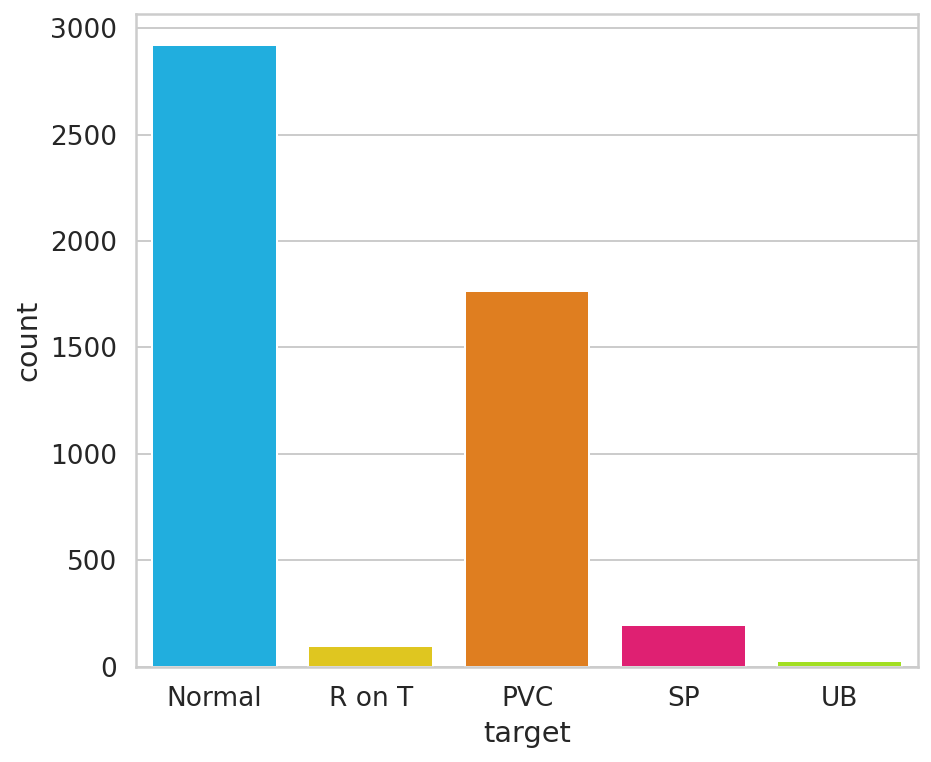

In [ ]:
plt.figure(figsize=(7,6))
ax = sns.countplot(df.target)
ax.set_xticklabels(class_names)

**The normal class is having the highest number of examples, This is good as we are going to train the model with the normal ecg signal records**

In [ ]:
data = df[df.target == '1'] \
    .drop(labels='target', axis=1) \
    .mean(axis=0) \

In [ ]:
print(data)

att1@NUMERIC     -0.374098
att2@NUMERIC     -2.204883
att3@NUMERIC     -3.291597
att4@NUMERIC     -3.955333
att5@NUMERIC     -3.858271
                    ...   
att136@NUMERIC    0.631438
att137@NUMERIC    0.512438
att138@NUMERIC    0.487634
att139@NUMERIC    0.565697
att140@NUMERIC   -0.525743
Length: 140, dtype: float64


**We are calculating the mean of all the 140 entries of a particular class**

In [ ]:
def plot_time_series_class(data, class_name, ax, n_steps=10):
  time_series_df = pd.DataFrame(data)

  smooth_path = time_series_df.rolling(n_steps).mean()
  path_deviation = 2 * time_series_df.rolling(n_steps).std()

  under_line = (smooth_path - path_deviation)[0]
  over_line = (smooth_path + path_deviation)[0]

  ax.plot(smooth_path, linewidth=2)
  ax.fill_between(
    path_deviation.index,
    under_line,
    over_line,
    alpha=.125
  )
  ax.set_title(class_name)

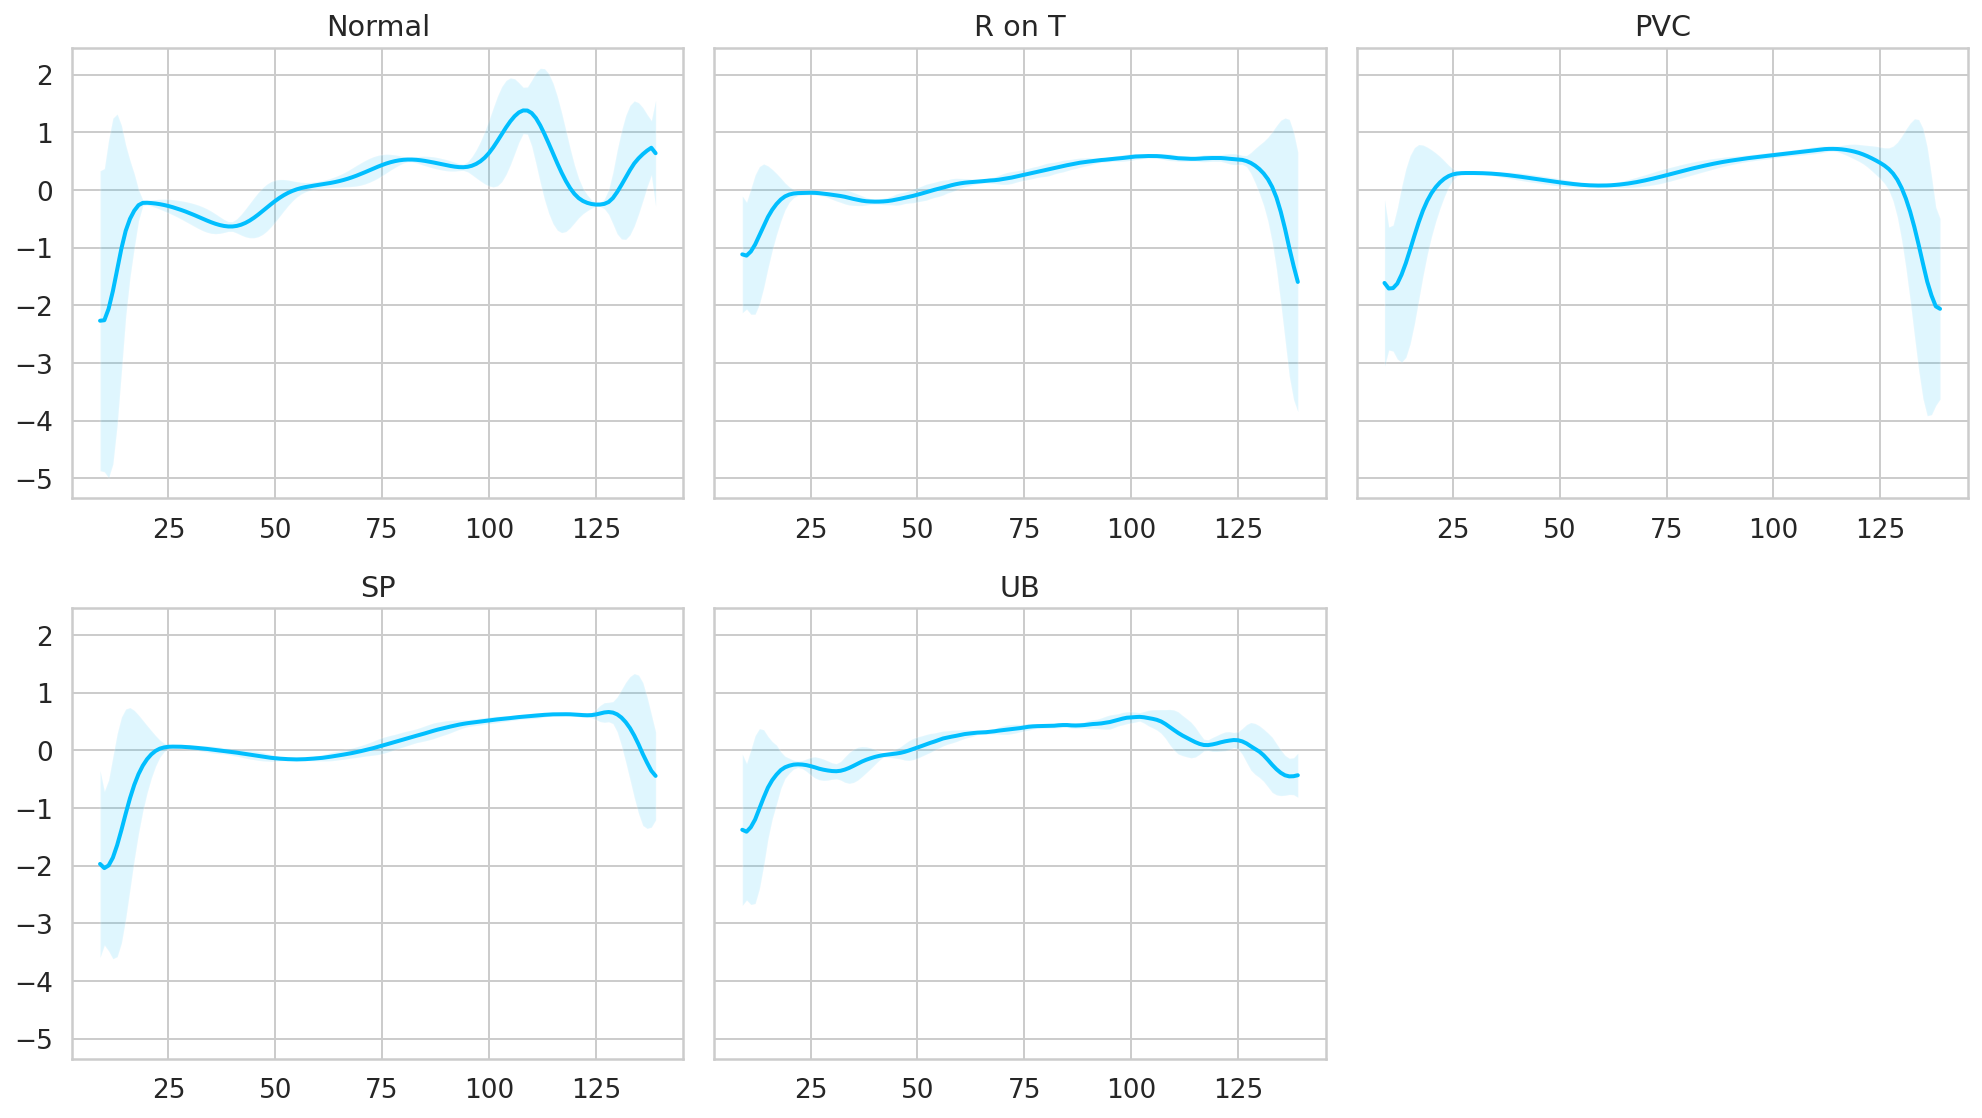

In [ ]:
classes = df.target.unique()

fig, axs = plt.subplots(
  nrows=len(classes) // 3 + 1,
  ncols=3,
  sharey=True,
  figsize=(14, 8)
)

for i, cls in enumerate(classes):
  ax = axs.flat[i]
  data = df[df.target == cls] \
    .drop(labels='target', axis=1) \
    .mean(axis=0) \
    .to_numpy()
  plot_time_series_class(data, class_names[i], ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout();

**In this plot, the dark line denotes the mean of the records of a particular class and the in between fillings denote the standard deeviation of those signals**

**It is seen that the normal signals are having distinct pattern than the rest of the classes, so that the model will be detect anamolies easier**

# **LSTM Autoencoder**

**The Autoencoder's job is to get some input data, pass it through the model, and obtain a reconstruction of the input. The reconstruction should match the input as much as possible. The trick is to use a small number of parameters, so your model learns a compressed representation of the data.

In a sense, Autoencoders try to learn only the most important features (compressed version) of the data. Here, we'll have a look at how to feed Time Series data to an Autoencoder. We'll use a couple of LSTM layers (hence the LSTM Autoencoder) to capture the temporal dependencies of the data.

To classify a sequence as normal or an anomaly, we'll pick a threshold above which a heartbeat is considered abnormal.**

**Reconstruction Loss
When training an Autoencoder, the objective is to reconstruct the input as best as possible. This is done by minimizing a loss function (just like in supervised learning). This function is known as reconstruction loss. Cross-entropy loss and Mean squared error are common examples.**

# **Anamoly detection in ECG data**

we are using normal ecg signal data for training the model. And using the reconstruction loss in autoencoder, we are detecting the anamoly signal from the normal data 

## **Data preprocessing**

In [ ]:
normal_df=df[df.target == str(CLASS_NORMAL)].drop(labels='target',axis=1)

In [ ]:
normal_df.shape

(2919, 140)

We will combine the rest of the classes as anamoly data 

In [ ]:
anomaly_df=df[df.target != str(CLASS_NORMAL)].drop(labels='target',axis=1)

In [ ]:
anomaly_df.shape

(2081, 140)

# **Train test validation split**

In [ ]:



train_df, val_df = train_test_split(normal_df,test_size=0.15,random_state = RANDOM_SEED)

val_df, test_df = train_test_split(val_df,test_size = 0.33, random_state = RANDOM_SEED)

In [ ]:
train_df.shape

(2481, 140)

In [ ]:
val_df.shape

(293, 140)

In [ ]:
test_df.shape

(145, 140)

**For training the auto encoder in pytorch, we have to convert the data into of type tensor**

In [ ]:
def create_dataset(df):

  sequences = df.astype(np.float32).to_numpy().tolist()

  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]

  n_seq, seq_len,n_features = torch.stack(dataset).shape

  return dataset, seq_len, n_features

Each Time Series will be converted to a 2D Tensor in the shape seq_len * n_features (140* 1in our case)

In [ ]:
train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

In [ ]:

train_dataset[0]

tensor([[ 2.4590e-01],
        [-2.3817e+00],
        [-3.3791e+00],
        [-4.1506e+00],
        [-4.3622e+00],
        [-3.6047e+00],
        [-2.2038e+00],
        [-1.6929e+00],
        [-1.4116e+00],
        [-4.5316e-01],
        [-2.4718e-01],
        [-3.0594e-01],
        [-3.0417e-01],
        [-2.8427e-01],
        [-3.1557e-01],
        [-3.4547e-01],
        [-2.9497e-01],
        [-2.6481e-01],
        [-2.9031e-01],
        [-3.4225e-01],
        [-2.9522e-01],
        [-2.9572e-01],
        [-3.0982e-01],
        [-3.0441e-01],
        [-2.9467e-01],
        [-2.8537e-01],
        [-5.3138e-01],
        [-4.3836e-01],
        [-4.7725e-01],
        [-5.1942e-01],
        [-6.5864e-01],
        [-6.1887e-01],
        [-6.9422e-01],
        [-7.1705e-01],
        [-7.0027e-01],
        [-7.2061e-01],
        [-8.0253e-01],
        [-6.7490e-01],
        [-6.7998e-01],
        [-6.5681e-01],
        [-5.8269e-01],
        [-5.0120e-01],
        [-4.1482e-01],
        [-4

In [ ]:
seq_len

140

In [ ]:
n_features

1

In [ ]:
len(train_dataset)

2481

## Encoder

In [ ]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))

The Encoder uses two LSTM layers to compress the Time Series data input.

Next, we'll decode the compressed representation using a Decoder:

## Decoder

In [ ]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

 Decoder contains two LSTM layers and an output layer that gives the final reconstruction.

In [ ]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

In [ ]:
model = RecurrentAutoencoder(seq_len, n_features, 128)
model = model.to(device)

# **Training**

In [ ]:
def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0
  
  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()

      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:

        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history

At each epoch, the training process feeds our model with all training examples and evaluates the performance on the validation set. Note that we're using a batch size of 1 (our model sees only 1 sequence at a time). We also record the training and validation set losses during the process.

we're minimizing the L1Loss, which measures the MAE (mean absolute error).  Because the reconstructions seem to be better than with MSE (mean squared error).

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

''

In [ ]:
model, history = train_model(
  model, 
  train_dataset, 
  val_dataset, 
  n_epochs=150
)

Epoch 1: train loss 71.11270824126397 val loss 56.73989361707668
Epoch 2: train loss 55.27537755262751 val loss 54.51208782521531
Epoch 3: train loss 49.016662245554 val loss 43.5407534394248
Epoch 4: train loss 42.28943835723213 val loss 40.85495192361773
Epoch 5: train loss 41.85147553151387 val loss 39.84538654744015
Epoch 6: train loss 41.59555054940989 val loss 39.53794641787688
Epoch 7: train loss 41.380173812321914 val loss 39.60446562783303
Epoch 8: train loss 41.24101049868343 val loss 39.50245162325914
Epoch 9: train loss 41.16746239314296 val loss 39.44768385838323
Epoch 10: train loss 41.06699038878029 val loss 39.470321001046344
Epoch 11: train loss 40.94097041507153 val loss 39.47878606815794
Epoch 12: train loss 40.84468791697209 val loss 39.39892343124025
Epoch 13: train loss 40.768132428111976 val loss 39.22082823209795
Epoch 14: train loss 40.68539422022533 val loss 39.197597881226
Epoch 15: train loss 40.62116816619479 val loss 39.21530828378307
Epoch 16: train loss 

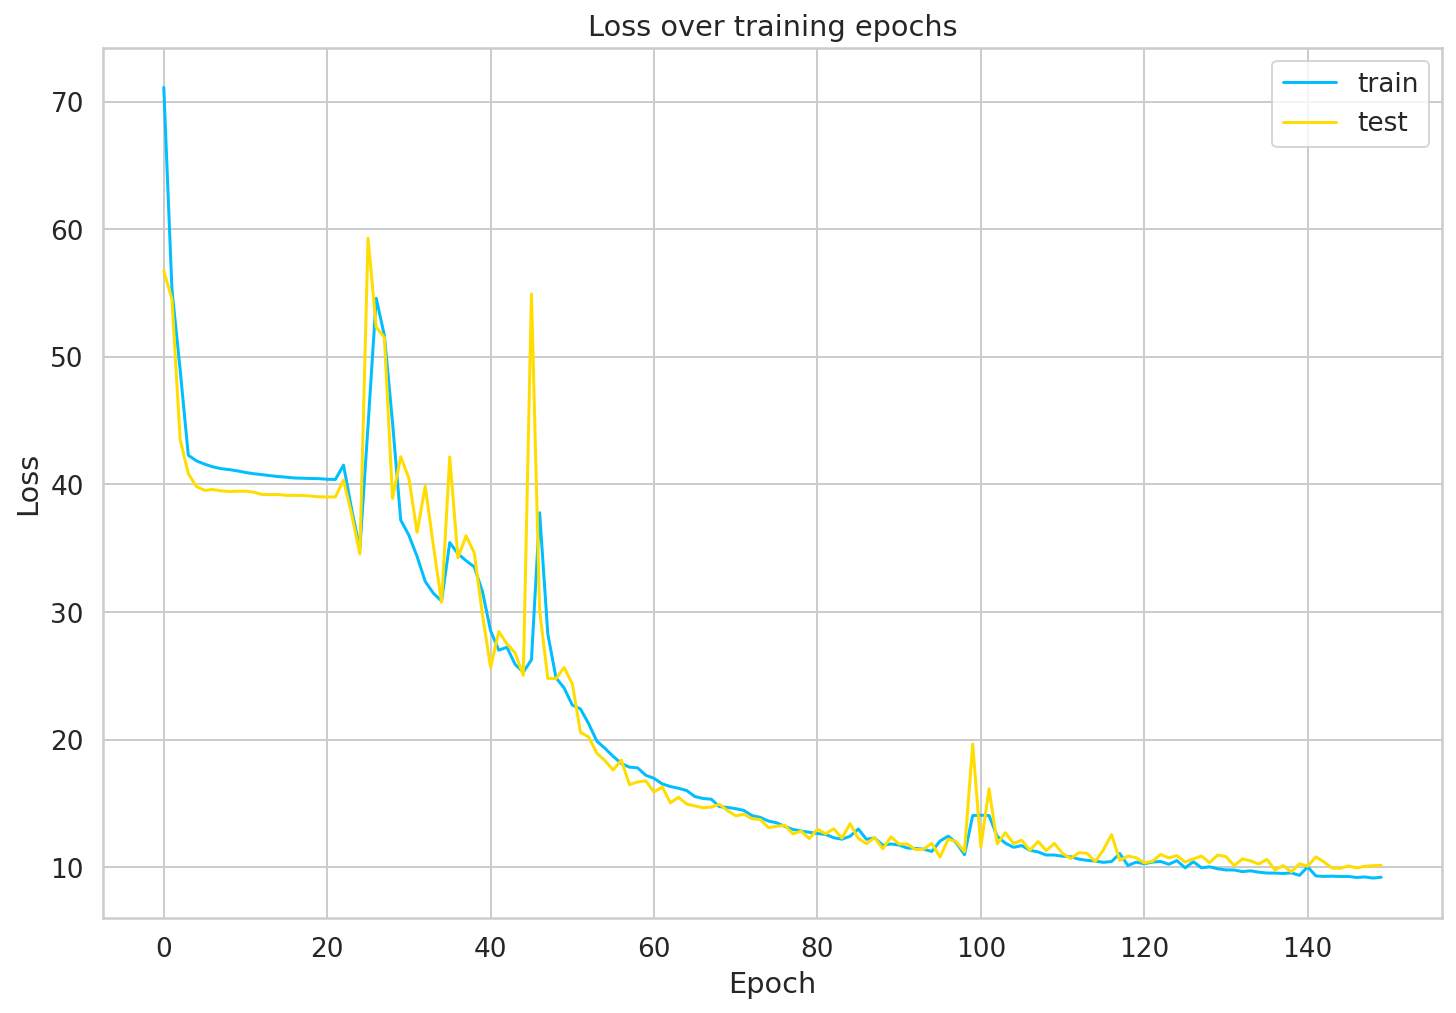

In [ ]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

# Saving the model

In [ ]:
MODEL_PATH = 'model.pth'

torch.save(model, MODEL_PATH)

In [ ]:
MODEL_PATH = 'model.pkl'

torch.save(model, MODEL_PATH)

In [ ]:
# !gdown --id 1jEYx5wGsb7Ix8cZAw3l5p5pOwHs3_I9A
# model = torch.load('model.pth')
# model = model.to(device)

# Choosing threshold

In [ ]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

**Function goes through each example in the dataset and records the predictions and losses. Let's get the losses and have a look at them**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


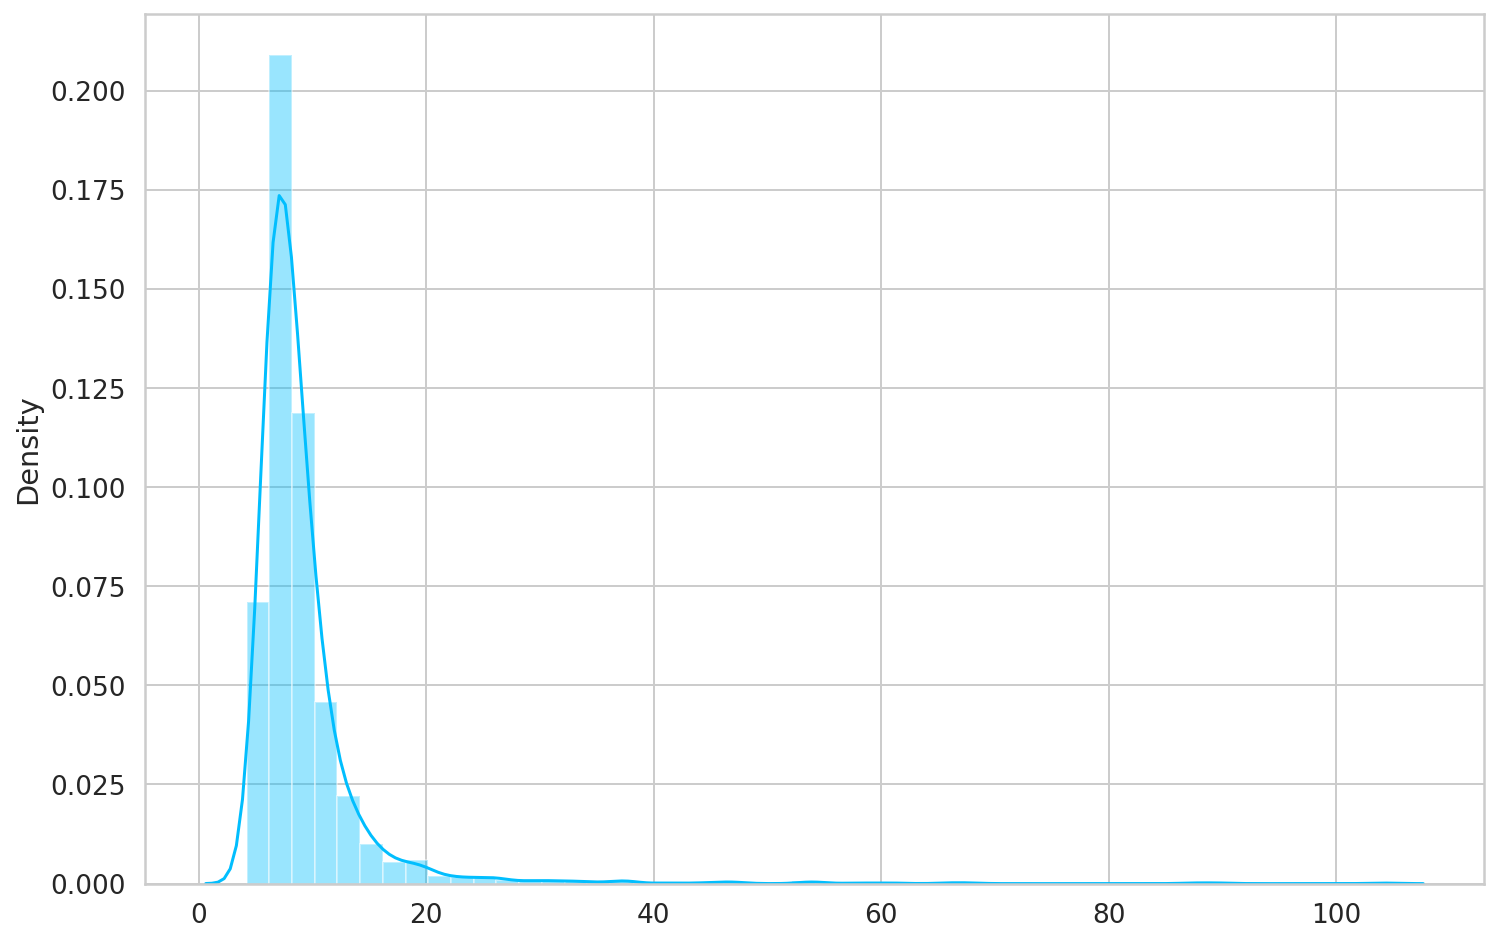

In [ ]:
_, losses = predict(model, train_dataset)

sns.distplot(losses, bins=50, kde=True)

In [ ]:
THRESHOLD = 26

# Evaluation

Using the threshold, we can turn the problem into a simple binary classification task:

-  If the reconstruction loss for an example is below the threshold, we'll classify it as a normal heartbeat
-  Alternatively, if the loss is higher than the threshold, we'll classify it as an anomaly

## Normal heartbeat

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


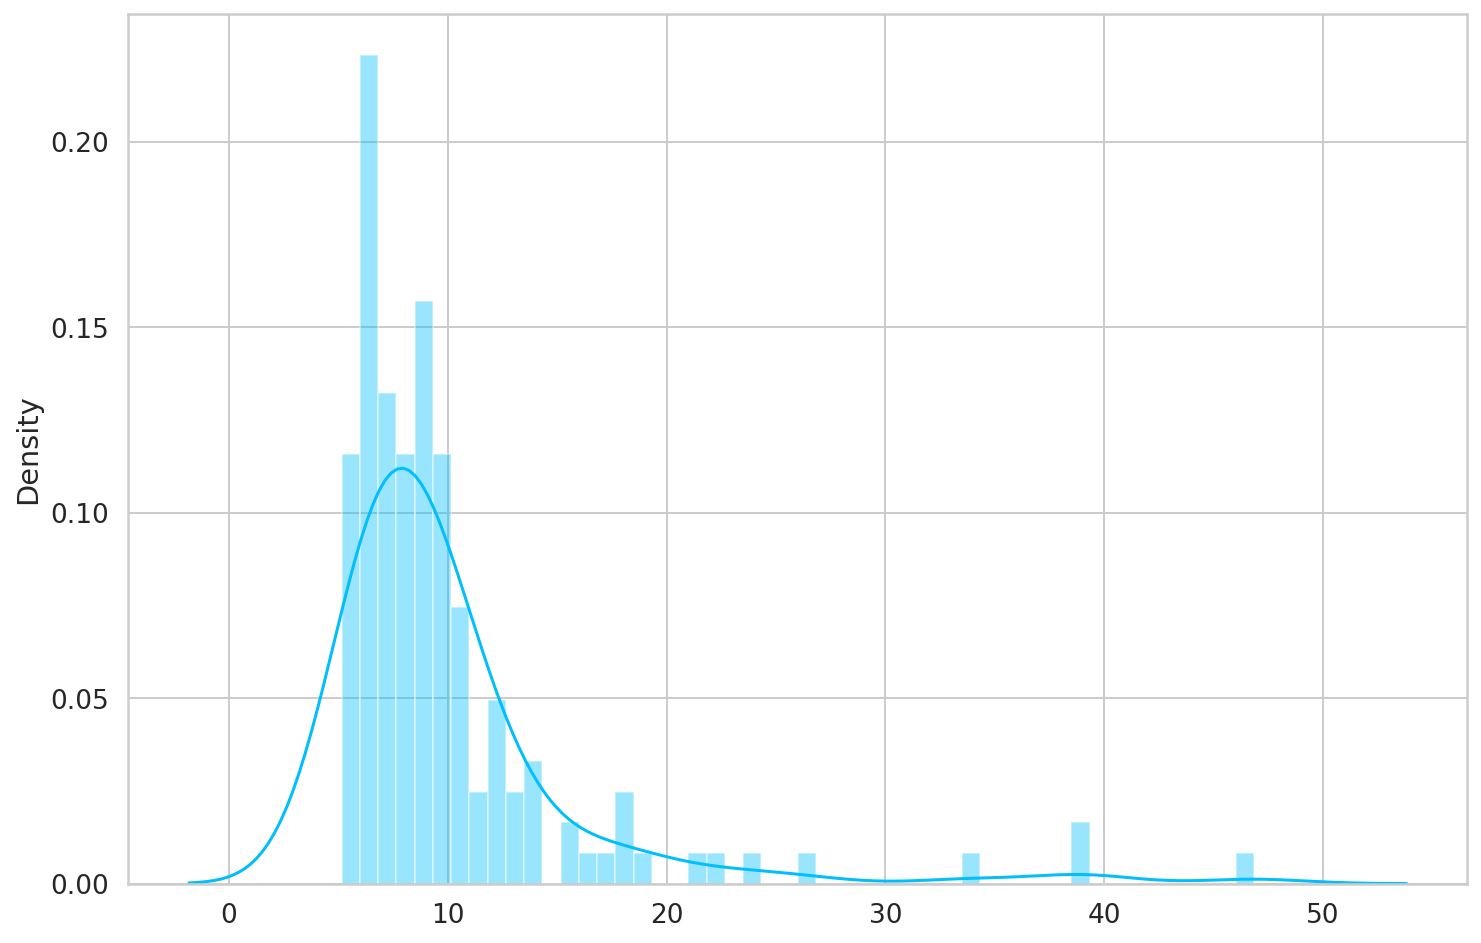

In [ ]:
predictions, pred_losses = predict(model, test_normal_dataset)
sns.distplot(pred_losses, bins=50, kde=True)

**Let's count the correct predictions**

In [ ]:
correct = sum(l <= THRESHOLD for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

Correct normal predictions: 140/145


# Anamolies

In [ ]:
anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


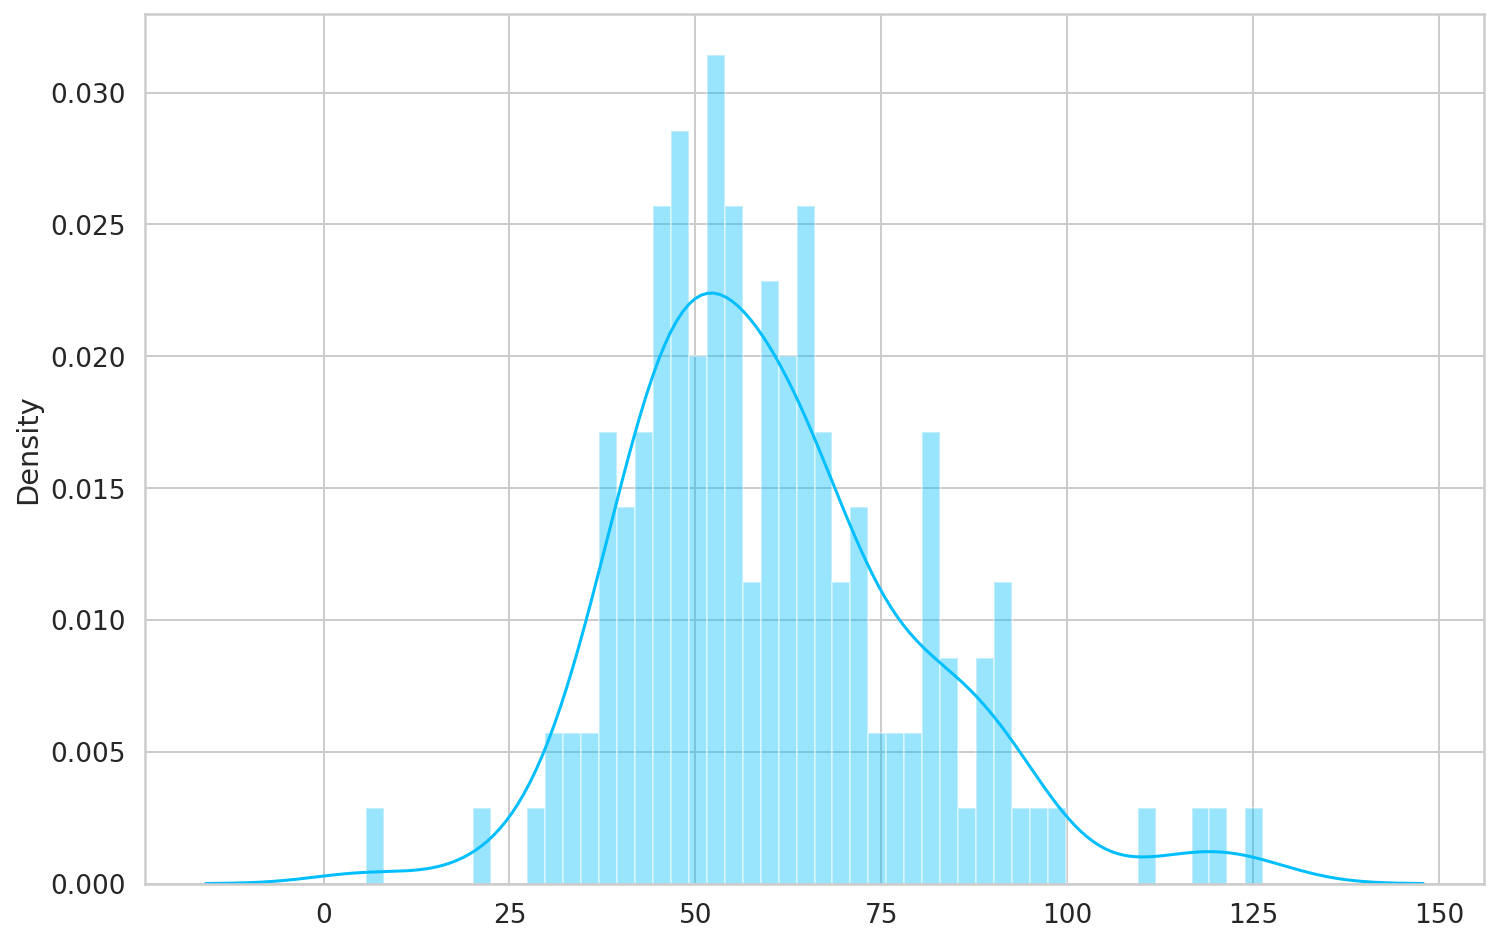

In [ ]:
predictions, pred_losses = predict(model, anomaly_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

In [ ]:
correct = sum(l > THRESHOLD for l in pred_losses)
print(f'Correct anomaly predictions: {correct}/{len(anomaly_dataset)}')

Correct anomaly predictions: 143/145


# Example 

In [ ]:
def plot_prediction(data, model, title, ax):
  predictions, pred_losses = predict(model, [data])

  ax.plot(data, label='true')
  ax.plot(predictions[0], label='reconstructed')
  ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
  ax.legend()

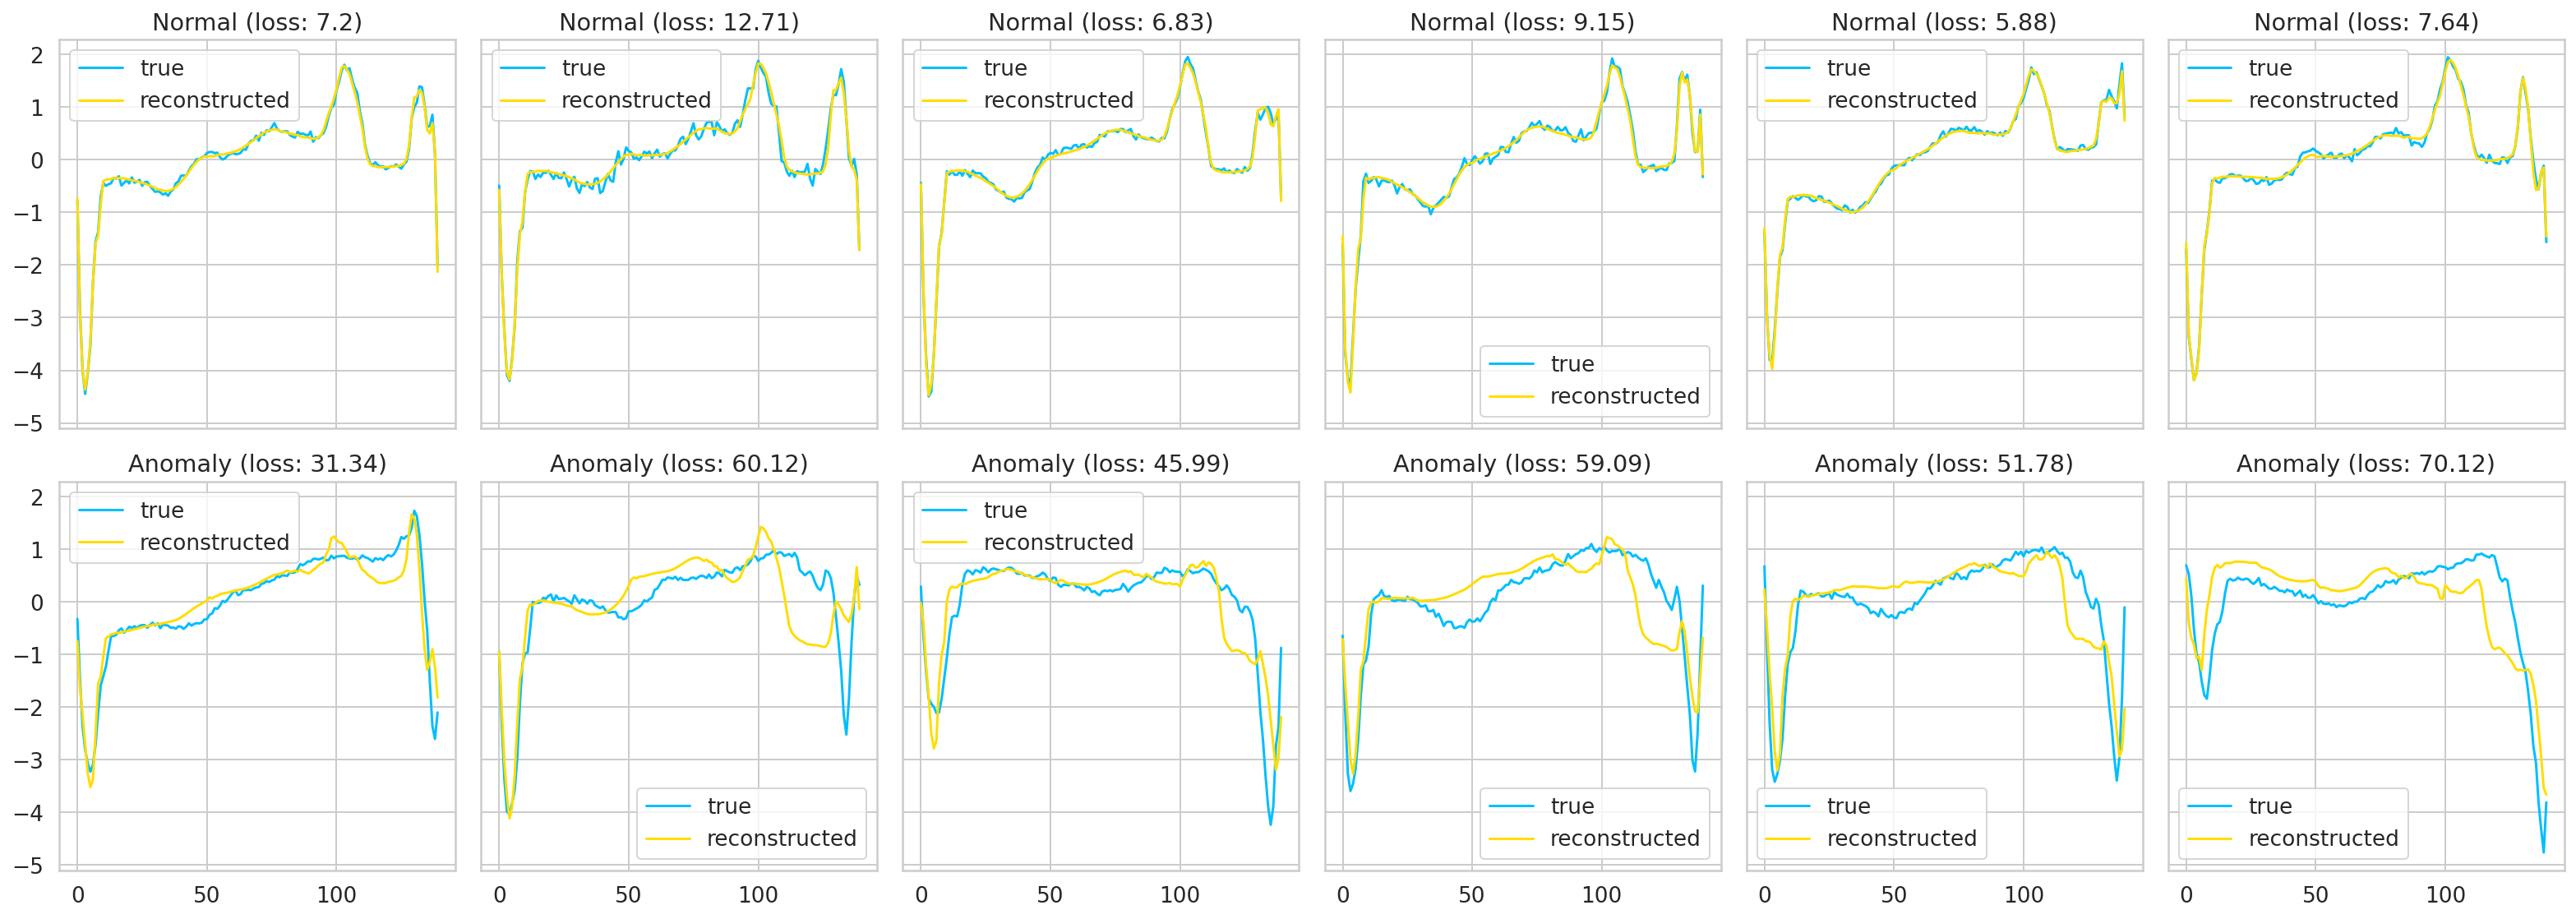

In [ ]:
fig, axs = plt.subplots(
  nrows=2,
  ncols=6,
  sharey=True,
  sharex=True,
  figsize=(22, 8)
)

for i, data in enumerate(test_normal_dataset[:6]):
  plot_prediction(data, model, title='Normal', ax=axs[0, i])

for i, data in enumerate(test_anomaly_dataset[:6]):
  plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

fig.tight_layout();

**Thus we can see that the model clearly identifies the anamoly ecg signal from the normal data samples. This looks good for the model**